## Training SSP on The Cells Dataset

In [1]:
import numpy as np
import os
import time
import torch
import matplotlib.pyplot as plt
import random

from torch.utils.data import DataLoader
from copy import deepcopy
from PIL import Image, ImageOps
from util.utils import set_seed, mIOU, visualize 
from torch.nn import CrossEntropyLoss, DataParallel
from torch.optim import SGD
from tqdm import tqdm
from torchvision import transforms
from model.SSP_matching import SSP_MatchingNet
from dataset.cells_dataset import CellsDataset

In [2]:
def normalize(img, mask):
    """
    :param img: PIL image
    :param mask: PIL image, corresponding mask
    :return: normalized torch tensor of image and mask
    """
    img = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])(img)
    mask = torch.from_numpy(np.array(mask)).long()
    return img, mask

In [3]:
def hflip(img, mask):
    '''Horizontally flips the image.'''
    if random.random() < 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
        mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
    return img, mask

In [4]:
def crop(img, mask, size):
    # padding height or width if smaller than cropping size
    w, h = img.size
    padw = size - w if w < size else 0
    padh = size - h if h < size else 0
    img = ImageOps.expand(img, border=(0, 0, padw, padh), fill=0)
    mask = ImageOps.expand(mask, border=(0, 0, padw, padh), fill=255)

    # cropping
    w, h = img.size
    x = random.randint(0, w - size)
    y = random.randint(0, h - size)
    img = img.crop((x, y, x + size, y + size))
    mask = mask.crop((x, y, x + size, y + size))

    return img, mask

In [5]:
def freeze_weights(model):
    for param in model.layer0.parameters():
        param.requires_grad = False
    for param in model.layer1.parameters():
        param.requires_grad = False

    for module in model.modules():
        if isinstance(module, torch.nn.BatchNorm2d):
            for param in module.parameters():
                param.requires_grad = False

In [6]:
def evaluate(model, dataloader, args):
    tbar = tqdm(dataloader)

    if args['dataset'] == 'pascal':
        num_classes = 21
    elif args['dataset'] == 'cells':
        num_classes = 2
    else:
        num_classes = 81
    metric = mIOU(num_classes)

    for i, (img_s_list, mask_s_list, img_q, mask_q, cls, _, id_q) in enumerate(tbar):
        img_q, mask_q = img_q.to(args['device']), mask_q.to(args['device'])
        for k in range(len(img_s_list)):
            img_s_list[k], mask_s_list[k] = img_s_list[k].to(args['device']), mask_s_list[k].to(args['device'])
        cls = cls[0].item()

        with torch.no_grad():
            out_ls = model(img_s_list, mask_s_list, img_q, mask_q)
            pred = torch.argmax(out_ls[0], dim=1)
        pred[pred == 1] = cls
        mask_q[mask_q == 1] = cls

        metric.add_batch(pred.cpu().numpy(), mask_q.cpu().numpy())

        tbar.set_description("Testing mIOU: %.2f" % (metric.evaluate() * 100.0))
    return metric.evaluate() * 100.0

In [7]:
def train_model(model, train_loader, test_loader, criterion, optimizer, args, save_path):
    # Model device casting
    model = DataParallel(model).to(args['device'])
    best_model = None
    iters = 0
    total_iters = args['episode'] // args['batch_size']
    lr_decay_iters = [total_iters // 3, total_iters * 2 // 3]
    previous_best = 0
    epoch_total = args['episode'] // args['snapshot']
    
    for epoch in range(epoch_total):
        print("\n==> Epoch %i of %i, learning rate = %.5f\t\t\t\t Previous best = %.2f"
              % (epoch + 1,epoch_total, optimizer.param_groups[0]["lr"], previous_best))

        # Puts the model in training mode
        model.train()

        for module in model.modules():
            if isinstance(module, torch.nn.BatchNorm2d):
                module.eval()

        total_loss = 0.0
        tbar = tqdm(train_loader)
        set_seed(int(time.time()))

        for i, (img_s_list, mask_s_list, img_q, mask_q) in enumerate(tbar):
            # Casting the images to the device
            img_q, mask_q = img_q.to(args['device']), mask_q.to(args['device'])
            for k in range(len(img_s_list)):
                img_s_list[k], mask_s_list[k] = img_s_list[k].to(args['device']), mask_s_list[k].to(args['device'])

            out_ls = model(img_s_list, mask_s_list, img_q, mask_q)
            mask_s = torch.cat(mask_s_list, dim=0)

            # computing self support loss
            if args['refine']:
                loss = criterion(out_ls[0], mask_q) + criterion(out_ls[1], mask_q) + criterion(out_ls[2], mask_q) + criterion(out_ls[3], mask_s) * 0.2
            else:
                loss = criterion(out_ls[0], mask_q) + criterion(out_ls[1], mask_q) + criterion(out_ls[2], mask_s) * 0.2

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            iters += 1

            if iters in lr_decay_iters:
                optimizer.param_groups[0]['lr'] /= 10.0
            tbar.set_description('Loss: %.3f' % (total_loss / (i + 1)))

            # Tensorboard log
            with train_summary_writer.as_default():
              summary.scalar('total loss', total_loss, step = epoch)

    #     miou = evaluate(model, test_loader, args)
    #     if miou >= previous_best:
    #             best_model = deepcopy(model)
    #             previous_best = miou
    # # o total mIOU será alterado quando a avaliação do modelo estiver implementada
    # total_miou = 0.0
    # saving the model
    best_model = deepcopy(model)
    torch.save(best_model.module.state_dict(),save_path)

Defining the network hyperparams and configs

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
args = {
    'data_root': 'data/CellsDatasetOriginal',            #  - root path of training dataset
    'dataset':'cells',                    #  - training dataset
    'batch_size': 1,                      #  - batch size of training
    'lr': 0.001,                          #  - learning rate
    'crop_size':473,                      #  - cropping size of training samples
    'backbone': 'resnet50',               #  - backbone of semantic segmentation model
    'refine': False,
    'fold': 0,                            #  - validation fold
    'shot': 1,                            #  - number of support pairs
    'episode': 5,                         #  - total episodes of training
    'snapshot': 5,                        #  - save the model after each snapshot episodes
    'seed': 1,                            #  - random seed to generate tesing samples
    'device': device
}
args['device']

device(type='cpu')

In [9]:
# The total number of epochs is computed dividing the episode param 
num_of_epochs = args['episode'] // args['snapshot']
num_of_epochs

1

In [10]:
def get_loaders(data_root, batch_size):
    '''Returns the train and test dataset'''
    train_set = CellsDataset(data_root, mode = 'train')
    train_loader = DataLoader(
        train_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2, drop_last=True)

    test_set = CellsDataset(data_root, mode = 'val')
    testloader = DataLoader(
        test_set, batch_size=1, shuffle=False, pin_memory=True, num_workers=2, drop_last=False)
    return train_loader, testloader

Obtaining the train and test dataset.

In [11]:
train_loader, test_loader = get_loaders(args['data_root'], args['batch_size'])

['1', '2', '3', '4', '5', '6']
['7', '8', '9', '10']


Instantiating the ssp model with the pre-defined configurations.

In [12]:
model = SSP_MatchingNet(args['backbone'], args['refine'])
model

SSP_MatchingNet(
  (layer0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [13]:
import datetime
from tensorflow import summary

2024-05-07 19:16:51.362966: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 19:16:52.815772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [14]:
current_time = str(datetime.datetime.now().timestamp())
train_log_dir = 'logs/tensorboard/train/' + current_time
test_log_dir = 'logs/tensorboard/test/' + current_time
train_summary_writer = summary.create_file_writer(train_log_dir)
test_summary_writer = summary.create_file_writer(test_log_dir)

In [15]:
%load_ext tensorboard

In [16]:
%tensorboard --logdir logs/tensorboard

In [17]:
MODEL_SAVE_PATH = f"./checkpoints/{args['backbone']}_{args['shot']}shot.pth"

In [18]:
# Defining the loss function and the optimizer
criterion = CrossEntropyLoss(ignore_index=255)
optimizer = SGD([param for param in model.parameters() if param.requires_grad],
                lr=args['lr'], momentum=0.9, weight_decay=5e-4)

In [19]:
# Training the model
train_model(model, train_loader, test_loader, criterion, optimizer, args, MODEL_SAVE_PATH)


==> Epoch 1 of 1, learning rate = 0.00100				 Previous best = 0.00


Loss: 0.062: 100%|██████████| 6/6 [01:32<00:00, 15.33s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


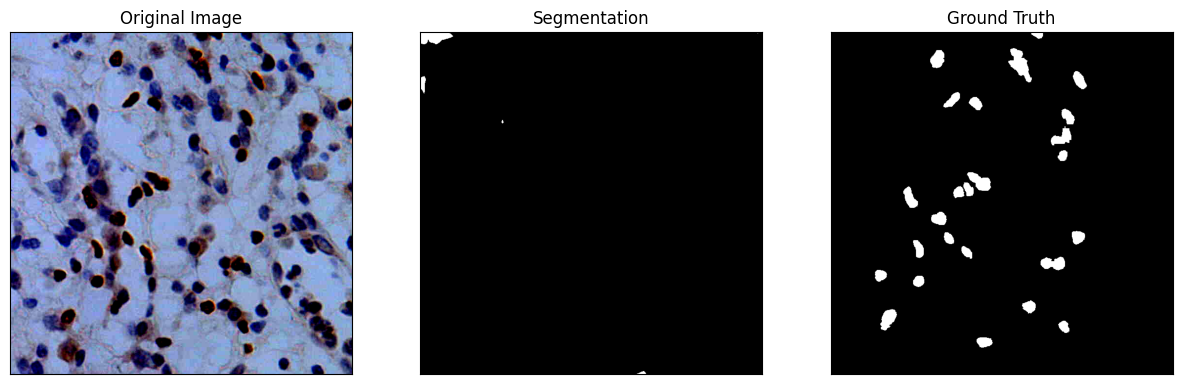

: 

In [20]:
model.eval()
i = 0
for img_s_list, mask_s_list, img_q, mask_q in test_loader:
    img_q, mask_q = img_q.to(args['device']), mask_q.to(args['device'])
    for k in range(len(img_s_list)):
        img_s_list[k], mask_s_list[k] = img_s_list[k].to(args['device']), mask_s_list[k].to(args['device'])
    out_ls = model(img_s_list, mask_s_list, img_q, mask_q)
    img = img_q.squeeze(0)
    pred = torch.argmax(out_ls[0], dim=1)
    plot_img = img.detach().cpu().numpy().transpose(1,2,0)
    plot_mask = mask_q.detach().cpu().numpy().transpose(1,2,0)
    plot_pred = pred.detach().cpu().numpy().transpose(1,2,0)

    plot_mask = (plot_mask.squeeze(2))
    plot_pred = (plot_pred.squeeze(2))
    visualize(Original_Image=plot_img, Segmentation=plot_pred, Ground_Truth=plot_mask)
    i += 1